# Exercise 8: hydrocarbons on platinum: functional-sensitive adsorption energies
**SOLUTION**: adopted from: S. Kourosh

Date: Wednesday, 19. April 2023

**Submission deadline**: Sunday, 23. April 2023 (or Sunday, 30. April 2023)

## 0. Introduction to the problem

In this exercise we will continue our study of density-functional theory (DFT) by considering the adsorption of three hydrocarbons -- benzene, methane, and ethane -- on a platinum slab. In principle, there are three candidates as adsorption sites, namely directly centered on top of a Pt atom, on the bridge connecting two Pt atoms, or on a hollow juncture in the middle of four Pt atoms.

![Three different hydrocarbons on the Pt(111) surface.](hydrocarbons_on_pt.png "Figure 1")

The aim of this exercise is to simulate the chemisorption of these hydrocarbons on platinum: in chemisorption, interactions between the molecule and substrate lead to bonds being formed, such that the bonds within the molecule and the surface are rearranged. We will be making use of [this paper [1]](https://pubs.rsc.org/en/content/articlepdf/2015/cp/c5cp04534g) in the course of this exercise. The first step is to make use of the definition of the adsorption energy $E_{ads}$:

\begin{equation*}
E_{ads} =  E_{total} - \sum_{slab, \, molecules} E_{separate \, system}
\end{equation*}

Thus, for our system:
\begin{equation}
E_{ads} = E_{total} - E_{Pt \, slab} - E_{molecule}
\end{equation}

Practically this means that three geometry optimizations are necessary: the first consisting of the total system of the molecule and the slab; the second with only the molecule; and the third with only the slab. However, not all DFT calculations can reproduce this result. Because of their different properties and approximations for the exchange–correlation (XC) part, *different DFT functionals predict different properties*, especially in regards to van der Waals interactions, which we have indeed already met in the third exercise via the Lennard-Jones potential.

Every functional has its advantages and disadvantages and can be more or less suitable for the specific system and/or property that you want to study. Thus, it is necessary to understand the limits of the functional that you want to use, e.g. searching in the literature or performing some preliminary benchmark calculations. 

To give you a flavour of how properties can change, in this exercise we (you) will investigate two from the same family of approximations to the XC energy, namely the generalized gradient approximation (GGA) functional, and we will use the GGA with vdW corrections: thus, in this exercise, we will examine a total of two different XC functionals, both with vdW corrections. Different from exercise 3, this time, we will include the vdW correction via the BEEF-vdW XC functional instead of via a simple LJ potential. In any case, the vdW correction is an energy term which is added *a posteriori* to the energy functional obtained from the variational principle of DFT.

The GGA formalism goes a step further than that of the local density approximation, accounting also for the local change of the electron density, with the inclusion of the electron density gradient in the functional. GGA functionals go through another division based on the origin of their parameters: They can be either empirical, i.e. derived from fitting of data coming from experiments and more sophisticated techniques, or determined from properties of the homogeneous electron gas as well as exact constraints.

LDA generally overestimates the bond strength between the molecule and the surface, since it is more suitable to describe strong bonds. This leads to a calculated overbinding, such as short adsorption bond lengths, large chemisorption energies, and high molecule–surface vibrational frequencies. The error in the chemisorption energy can be so large that LDA may predict the wrong chemisorption site. Finally, by considering vdW corrections via the BEEF-vdW functional, we take into account non-local effects which may play a role in the chemisorption process.

## 1: Benzene $\text{C}_6\text{H}_6$ on Pt(111)

We begin by logging into our accounts on JupyterHub on Euler in a similar manner as described in the previous exercises, and `pull` the newest exercise files from the GitHub repository, making sure that you are in the directory for the course:
```bash
    $ cd ~/Molecular-and-Materials-Modelling-FS2023
    $ git init
  # $ git stash
    $ git pull https://github.com/ramador09/Molecular-and-Materials-Modelling-FS2023.git
```  

First, execute the following two cells to import necessary modules and libraries, and to define the `view_structure()` function, which we will make ample use of in the course of this exercise:

In [1]:
import numpy as np
from ase.io import read, write
from ase.visualize import view
from ase.build import fcc111,add_adsorbate,molecule
import matplotlib.pyplot as plt
import nglview as nv

In [2]:
def view_structure(system):
    t = nv.ASEStructure(system) 
    w = nv.NGLWidget(t, gui=True)
   # w.add_spacefill()
    return w

Next, we create an instance of the `molecule` class by starting with the benzene molecule. ASE is "smart" enough to know that we mean the benzene molecule when we simply create an instance of the `molecule` class and feed it the string `C6H6`:

In [3]:
benzene=molecule('C6H6')

In [4]:
view_structure(benzene)

NGLWidget()

We will need this object later for the structure relaxation of the benzene molecule. Let's save it now:

In [5]:
# write(filename='./benzene/benzene_mol.xyz',images=benzene)

Now, having initialised the `benzene` object, we can place it on the surface of Pt(111) by executing the following cell. **Note**: the lateral size of the supercell is related with the periodic simulation box parameters in the CP2K input file. These have already been chosen and adjusted to the (6,6,3) case, so please do not change the values in the `size` argument without adjusting the `CELL` parameters in the CP2K input file. If this sentence confuses you, just ignore it and change as little as possible ;-)

In [6]:
benz_pt_slab=fcc111('Pt',size=(6,6,5))
write(filename='./pt_slab/pt_slab.xyz',images=benz_pt_slab) # Writes the slab to a file
add_adsorbate(benz_pt_slab,benzene,height=2.25,position=(10,7)) # Adsorbs benzene on the slab
benz_pt_slab.center(vacuum=10, axis=2)
view_structure(benz_pt_slab)

/Users/kourosh/anaconda3/lib/python3.9/site-packages/ase/io/extxyz.py:302: UserWarning: Skipping unhashable information adsorbate_info
  warnings.warn('Skipping unhashable information '


NGLWidget()

Use the `get_cell()` method on this `Atoms` object to view the unit cell of the system. This will serve as a good sanity check during the calculations, and moreover, we will need to use these values in the `CELL` subsection of the CP2K input file:

In [7]:
benz_pt_slab.get_cell()

Cell([[16.6311514935076, 0.0, 0.0], [8.3155757467538, 14.402999687565085, 0.0], [0.0, 0.0, 31.302852220893335]])

Save the slab-and-molecule composite system by executing the `write` function from the `ase.io` library:

In [8]:
# write(filename='./benzene/benzene_on_pt.xyz',images=benz_pt_slab)

## 1.1. Connecting to the Eiger supercomputer

Due to the bugs and glitches on Euler, we will try to submit and run calculations on the Piz Eiger supercomputer in Lugano. We will do this by connecting via ssh to Eiger from Euler. In the current repository, you will see a directory called `eiger_connect`. Open the `README.txt` file and execute each of the lines, line by line, in your command line:

```bash
$ cd eiger_connect
$ cp config $HOME/.ssh
$ cp id_rsa $HOME/.ssh
$ chmod 644 $HOME/.ssh/id_rsa
$ chmod 644 $HOME/.ssh/config
$ chmod 700 $HOME/.ssh/id_rsa
$ ssh eiger
```

Once you `ssh` to Eiger, you will be in Daniele's `$SCRATCH` directory on Eiger. It is here where we will submit the calculations.

The `run` file is the submission script, and, for the purposes of this exercise, should **not** be modified. In the current `$SCRATCH` directory, make a new directory with your username on Euler:

```bash
$ mkdir <username>
$ cd <username>
```

It is within this `<username>` subdirectory that each student will submit calculations. Copy the `run` file from the parent `$SCRATCH` directory into the current `<username>` directory:

```bash
$ cp ../run .
```

## 1.2. `rsync`'ing your files to Eiger

Either on your local machine or on Euler (whichever you are `ssh`'ing to Eiger from, and whichever you have been executing the above code in), open a terminal. We need to sync the files we just generated to Eiger in order to run them. Issue the following command (again: on whatever machine you generated the above files, either on Jupyter@Euler or on your local machine):

```bash
$ rsync -av pt_slab benzene eiger:<username> 
```

where you replace `<username>` with the `username` folder you made above on Eiger (the angle brackets are merely placeholders and shouldn't appear in the final execution!). If everything worked, you should see the generated files now on Eiger. Switch now to the Eiger terminal now and let's look at the input files.

## 1.3. Modifying the input file and navigating around

Your cloned `exercise8` directory already has the input file template `input.inp` and the BEEF-vdW directive `beefvdw.inc` in the subdirectories named after the molecules. You will need to make appropriate modifications to the input files, in order for the calculations to run. **Important**: it is always good practice to follow the motto: "one directory, one calculation". Let's move into the `benzene` directory, make separate subdirectories for the full molecule-slab system and the molecule itself. Then we copy the input file template to, say, the full molecule-slab system, move the full geometry file to the full directory, and lastly open the input file with `vim`:

```bash
$ mkdir benzene; cd benzene
$ mkdir full; mkdir mol; cd full
$ cp ../../input.inp ./benzene_on_pt.inp
$ mv ../../benzene_on_pt.xyz .
$ vi benzene_on_pt.inp
```

**Important**: You will need to modify all instances of the string `MOLECULE` (this is just a template after all), as well as (possibly) the values of the `&CELL` section, depending on the values of the `get_cell()` function above. 

In order to submit a job, make sure you're in the appropriate subdirectory containing your input and geometry files (and make sure the `run` script is there also of course), and issue

```bash
$ sbatch -J <username>  --export=ALL,root=<input_file> run
```

where `<username>` is your Euler (!) username, and `<input_file>` is the name of the input file in the respective directory. To check the status of the job submission, issue

```bash
$ squeue -u dpassero
```

(since we're using Daniele's scratch).

## 1.4. `rsync`'ing the output files back 

Once the calculation is finished, we need to `rsync` the output files back. Go to a "local" terminal (ie, either Euler or your truly local machine -- wherever you will be doing the postprocessing) and issue

```bash
$ rsync -av eiger:<username>/benzene/full .
```

## 1.5. A sidenote about convergence

In the interest of time, only do one job submission.

#### Assignment 1: Optimization of the Pt slab
Repeat the above steps to optimize the Pt slab. The geometry was already generated in the beginning of this notebook, and is contained in the `slab` directory. Copy the input file template and run script to the slab directory, make the necessary changes (don't forget to change as appropriate the values of the `CELL` subsection in the CP2K input file)! Then submit the calculation. The remaining parts of the input file should remain the same, because we want the simulations to be as similar as possible in order to compute the adsorption energy

**Important**: make sure to keep the same atoms fixed during the optimization of the slab!

In [9]:
# Find the values for the CELL subsection. The xyz header has [0 0 0] for C which causes an error in CP2K
pt_slab=fcc111('Pt',size=(6,6,5))
pt_slab.center(vacuum=10, axis=2)
pt_slab.get_cell()

Cell([[16.6311514935076, 0.0, 0.0], [8.3155757467538, 14.402999687565085, 0.0], [0.0, 0.0, 29.052852220893335]])

In [10]:
# !sbatch -J kshariat --export=ALL,root=pt_slab run

In [11]:
def view_trajectory(trajectory):
    t2 = nv.ASETrajectory(trajectory)
    w2 = nv.NGLWidget(t2, gui=True)
    return w2;

In [12]:
traj = read("pt_slab/pt_slab-pos-1.xyz", ":")
view_trajectory(traj)

NGLWidget(max_frame=28)

#### End Assignment 1

#### Assignment 2: Optimization of the benzene molecule
Repeat the procedure outlined in Assignment 1 for the beneze molecule, changing
all names of files as necessary. Remember, the geometry was already generated.

In [13]:
# change CELL to `PERIODIC NONE`
# !sbatch -J kshariat --export=ALL,root=benzene_mol run

In [14]:
traj = read("benzene/full/benzene_on_pt-pos-1.xyz", ":")
view_trajectory(traj)

NGLWidget(max_frame=62)

#### End Assignment 2

#### Assignment 3: Computation of the adsorption energy

Use your calculations from above and code from previous exercises to visualize the relaxation trajectory. We now have all the ingredients to compute the adsorption energy $E_{\text{ads}}$ of benzene on Pt(111) according to Eq. 1:

$$
E_{\text{ads}} = E_{\text{slab \& mol}} - E_{\text{slab}} - E_{\text{mol}}
$$

[Write a function to] compute the adsorption energy of benzene on the Pt(111) surface. The simplest and probably most straightforward way is to use the `grep` command to extract all instances of the total energy, then pipe this to the `tail` command (using the appropriate flags of course) to extract only the line containing last instance of the total energy (ie, the line converged value!), and finally to pipe this to the `awk '{print $3}'` command (the single ticks are crucial, do not forget them!), which will print the third column of this line, ie the total energy:

```bash
$ grep <expression for total energy> | tail <flags to extract only the last line> | awk '{print $3}'
```

In [15]:
%%bash

benzene_mol_e=$(grep "Total energy:" benzene/mol/benzene_mol.out | tail -1 | awk '{print $3}')
benzene_pt_e=$(grep "Total energy:" benzene/full/benzene_on_pt.out | tail -1 | awk '{print $3}')
pt_slab_e=$(grep "Total energy:" pt_slab/pt_slab.out | tail -1 | awk '{print $3}')

ha2ev=27.211386245988

echo The adsorption energy of benzene is $(echo "($benzene_pt_e - $benzene_mol_e - $pt_slab_e) * $ha2ev" | bc) eV

The adsorption energy of benzene is -.97477014230485 eV


#### End Assignment 3

## 2. Methane $\text{CH}_4$ on Pt(111)

We now repeat the above procedure for methane on Pt(111):

In [16]:
methane=molecule('CH4')
view_structure(methane)

NGLWidget()

In [18]:
meth_pt_slab = fcc111('Pt', size=(6, 6, 5))

# We don't have to write the slab file again, since we already did it above!

add_adsorbate(meth_pt_slab, methane, height=2.25, position=(10, 7))
meth_pt_slab.center(vacuum=10, axis=2)
view_structure(meth_pt_slab)

NGLWidget()

Let's look at the cell information again (**important for when/if we need to change the values in the input file!**)

In [19]:
meth_pt_slab.get_cell()

Cell([[16.6311514935076, 0.0, 0.0], [8.3155757467538, 14.402999687565085, 0.0], [0.0, 0.0, 31.931970220893334]])

In [20]:
# write(filename='./methane/methane_on_pt.xyz',images=meth_pt_slab)

#### Assignment 4: The adsorption energy of methane on Pt(111)

Repeat Assignments 1-3 in order to arrive at the adsorption energy Eq.
1 for methane on Pt(111), whose full geometry we have just generated. Hint: with all these different input and output files, it might
not be a bad idea to create separate directories to make everything a bit more
organised...

In [21]:
# !sbatch -J kshariat --export=ALL,root=methane_full run
# !sbatch -J kshariat --export=ALL,root=methane_mol run

In [22]:
traj_meth = read("methane/full/methane_on_pt-pos-1.xyz", ":")
view_trajectory(traj_meth)

NGLWidget(max_frame=42)

In [23]:
%%bash

methane_mol_e=$(grep "Total energy:" methane/mol/methane_mol.out | tail -1 | awk '{print $3}')
methane_pt_e=$(grep "Total energy:" methane/full/methane_on_pt.out | tail -1 | awk '{print $3}')
pt_slab_e=$(grep "Total energy:" pt_slab/pt_slab.out | tail -1 | awk '{print $3}')

ha2ev=27.211386245988

echo The adsorption energy of methane is $(echo "($methane_pt_e - $methane_mol_e - $pt_slab_e) * $ha2ev" | bc) eV

The adsorption energy of methane is .31650836467333 eV


#### End Assignment 4

#### Assignment 5: Adsorption of ethane
Repeat Assignments 1-3 in order to arrive at the adsorption energy Eq.
1 for ethane.

In [24]:
ethane=molecule('C2H6')
# write(filename='./ethane/ethane_mol.xyz',images=ethane)
eth_pt_slab = fcc111('Pt', size=(6, 6, 5))
add_adsorbate(eth_pt_slab, ethane, height=1.75, position=(10, 7))
eth_pt_slab.center(vacuum=10, axis=2)
view_structure(eth_pt_slab)

NGLWidget()

Notice how the ethane molecule is "vertical" (the axis of the molecule is perpendicular to the surface). In the paper, the ethane molecule is horizontal. We have to rotate the molecule 90° about the $y$-axis:

In [25]:
ethane.rotate('y', 90)
view_structure(ethane)

NGLWidget()

In [26]:
eth_pt_slab = fcc111('Pt', size=(6, 6, 5))
add_adsorbate(eth_pt_slab, ethane, height=2.25, position=(10, 7))
eth_pt_slab.center(vacuum=10, axis=2)
view_structure(eth_pt_slab)

NGLWidget()

This looks more like the structure in the paper. Now we can save it:

In [27]:
# write(filename='./ethane/ethane_on_pt.xyz',images=eth_pt_slab)

In [28]:
## -- Your code here
eth_pt_slab.get_cell()

Cell([[16.6311514935076, 0.0, 0.0], [8.3155757467538, 14.402999687565085, 0.0], [0.0, 0.0, 32.18529522089334]])

In [29]:
# !sbatch -J kshariat --export=ALL,root=ethane_full run
# !sbatch -J kshariat --export=ALL,root=ethane_mol run

In [30]:
traj_eth = read("ethane/full/ethane_on_pt-pos-1.xyz", ":")
view_trajectory(traj_eth)

NGLWidget(max_frame=46)

In [31]:
%%bash

ethane_mol_e=$(grep "Total energy:" ethane/mol/ethane_mol.out | tail -1 | awk '{print $3}')
ethane_pt_e=$(grep "Total energy:" ethane/full/ethane_on_pt.out | tail -1 | awk '{print $3}')
pt_slab_e=$(grep "Total energy:" pt_slab/pt_slab.out | tail -1 | awk '{print $3}')

ha2ev=27.211386245988

echo The adsorption energy of ethane is $(echo "($ethane_pt_e - $ethane_mol_e - $pt_slab_e) * $ha2ev" | bc) eV

The adsorption energy of ethane is .16682163299739 eV


#### End Assignment 5

#### Assignment 6: Comparative plots of the adsorption energy

Reproduce the bar graphs (both top and bottom plots -- the experimental adsorption energy is given in the paper's supplementary information) in Fig. 3 of [the paper](https://pubs.rsc.org/en/content/articlepdf/2015/cp/c5cp04534g) for your molecules benzene, methane, and ethane. 

<AxesSubplot:ylabel='$E_{ads}(exp) - E_{ads}(theo)\\ (eV)$'>

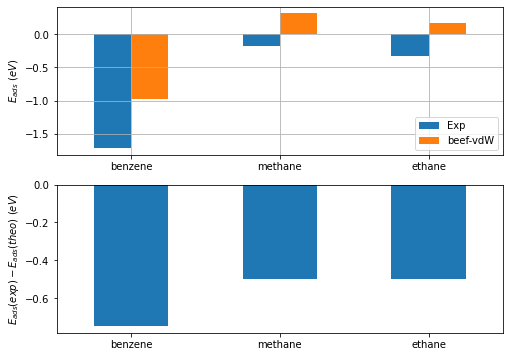

In [32]:
import pandas as pd

# gather the data in a dataframe, which is easier to plot
df = pd.DataFrame(data={
    'Exp': np.array([-1.72, -0.181, -0.331]), # extracted from the supplementary materials
    'beef-vdW': np.array([-.97477014230485, .31650836467333, .16682163299739]).round(3),
}, index=['benzene', 'methane', 'ethane'])

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

df.plot(kind='bar', rot=0, grid=True, ylabel=r'$E_{ads}\ (eV)$', ax=ax1)
(df['Exp'] - df['beef-vdW']).plot(kind='bar', rot=0,ylabel=r'$E_{ads}(exp) - E_{ads}(theo)\ (eV)$', ax=ax2)

#### End Assignment 6

### ----- Assignments 7-9 are optional, but worth quite a few points, for those of us who might have missed a few submissions ;-) -----

#### OPTIONAL Assignment 7: The Grimme D3 dispersion method

Repeat the above calculations, so that you obtain the adsorption energy Eq. 2 using now the Grimme D3 method. You
singly need to change the value of the `@include` directive in the input files from `"beefvdw.inc"` to `"grimme_d3.inc"`:

```
...
@include "grimme_d3.inc"
...
```

The `grimme_d3.inc` file is already in the parent `exercise8` directory and doesn't need to be modified. You might, however, depending on the relative location of the `grimme_d3.inc` file, need to modify the relative path of the `@include` statement above.

Reproduce the bar graphs for benzene, methane, and ethane in Figs. 3 (a) and (b) of
the paper linked in the PDF. Since we already did calculations for the BEEF-vdW functional,
of course these are the only ones you’ll plot. The experimental data for comparison
are given in Table S1 of the supplementary information of the paper (also linked in the PDF).

In [33]:
%%bash

# create a csv file with all the energies
outfile=adsorption.csv

echo "Method,Benzene,Methane,Ethane" > $outfile # csv header

echo "Exp,-1.72,-0.181,-0.331" >> $outfile # experimental data

# slab energies
pt_slab_bvdw=$(grep "Total energy:" pt_slab/pt_slab.out | tail -1 | awk '{print $3}')
pt_slab_grimme=$(grep "Total energy:" pt_slab_grimme/pt_slab.out | tail -1 | awk '{print $3}')

ha2ev=27.211386245988

printf "Grimme d3" >> $outfile
for sys in benzene methane ethane
do   
    mol_e=$(grep "Total energy:" $sys/mol_grimme/$sys\_mol.out | tail -1 | awk '{print $3}')
    full_e=$(grep "Total energy:" $sys/full_grimme/$sys\_on_pt.out | tail -1 | awk '{print $3}')
    printf ',%.3f' $(echo "($full_e - $mol_e - $pt_slab_grimme) * $ha2ev" | bc) >> $outfile
done
printf "\nBeef-vdW" >> $outfile
for sys in benzene methane ethane
do   
    mol_e=$(grep "Total energy:" $sys/mol/$sys\_mol.out | tail -1 | awk '{print $3}')
    full_e=$(grep "Total energy:" $sys/full/$sys\_on_pt.out | tail -1 | awk '{print $3}')
    printf ',%.3f' $(echo "($full_e - $mol_e - $pt_slab_bvdw) * $ha2ev" | bc) >> $outfile
done


<AxesSubplot:ylabel='$E_{ads}(exp) - E_{ads}(theo)\\ (eV)$'>

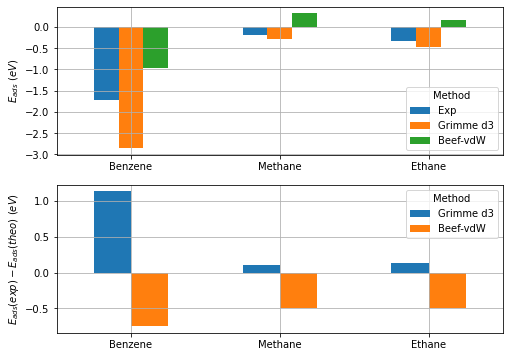

In [34]:
df = pd.read_csv('adsorption.csv', index_col=0).T

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

df.plot(kind='bar', rot=0, grid=True, ylabel=r'$E_{ads}\ (eV)$', ax=ax1)
(-df[['Grimme d3', 'Beef-vdW']].sub(df['Exp'], axis=0)).plot(kind='bar', rot=0, grid=True, ylabel=r'$E_{ads}(exp) - E_{ads}(theo)\ (eV)$', ax=ax2)

#### End Assignment 7

#### OPTIONAL Assignment 8: identification of bonding pairs

In identifying chemi- resp. physisorption, one of the most important quantities are the distances (in the relaxed geometry!) between atoms of the adsorbate and those of the substrate. Pick any of the above molecules (benzene, methane, ethane) and use the `get_distances()` function to compare the distances of the closest 2-3 molecule-substrate atom pairs between the starting geometry and the final relaxed geometry. Comment on your results.

The 3 closest atom pairs and their respective distances in the relaxed geometry are:
 (181, 165, 2.1652519033065647) (180, 164, 2.204085174402611) (185, 164, 2.212221905180444)


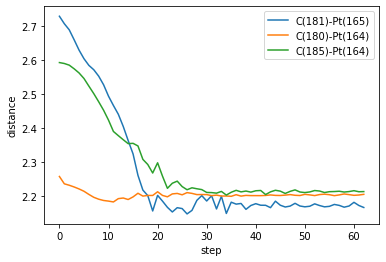

In [36]:
# benzene was chosen as the substrate
all_frames = read('benzene/full/benzene_on_pt-pos-1.xyz', ':')
relaxed_frame =  all_frames[-1] # select the last frame in the simulation

# seperate the substrate from the adsorbate
pts = np.arange(len(relaxed_frame))[relaxed_frame.get_atomic_numbers() == 78] # index of platin atoms
bnz = np.arange(len(relaxed_frame))[relaxed_frame.get_atomic_numbers() != 78] # index of benzene molecule

num_to_track = 3

dists = [(i, j, relaxed_frame.get_distance(i, j)) for i in bnz for j in pts]
pairs = sorted(dists, key=lambda x: x[2])[:num_to_track]
print(f'The {num_to_track} closest atom pairs and their respective distances in the relaxed geometry are:\n', *pairs)

dist_tracking = np.empty((len(all_frames), len(pairs)))

for i, frame in enumerate(all_frames):
    for j, pair in enumerate(pairs):
        dist_tracking[i, j] = frame.get_distance(pair[0], pair[1])

plt.plot(dist_tracking, label=[f'{relaxed_frame.symbols[i]}({i})-{relaxed_frame.symbols[j]}({j})' for i, j, _ in pairs])
plt.xlabel('step')
plt.ylabel('distance')
plt.legend()

According to the plot above, one of the bonding atom pairs retains its distance throughout the optimization. However, the other two start significantly further and become closer as the optimization progresses. This could be due to the fact that the initial placement of the substrate was further than optimal.

#### End Assignment 8

#### OPTIONAL Assignment 9: computation of the deformation energy

In the above geometry optimizations, you've probably noticed that the molecule "buckles" a little bit: this is due to the molecule's interaction with the substrate, which in turn performs work on the molecule to reach a total energy minimum. The objective of this optional assignment will be to calculate mechanical (or really... electrostatic) work that the substrate performs on the molecule. This simply amounts to the energy difference between the relaxed molecule in the gasphase $E_{\text{gasphase}}^{\text{relaxed}}$ and the energy of *just the molecule* in the relaxed adsorption configuration on the surface. Since we already have $E_{\text{gasphase}}^{\text{relaxed}}$ from our calculations from previous steps, we just need to extract the energy of the molecule on the surface.

1. Choose the molecule for which you see the "most" deformation in the course of the geometry optimization on the platinum slab (e.g., benzene on platinum, methane on platinum, or ethane on platinum. In any case, make sure it's the *total* system geometry that you choose, and not just the slab nor just the molecule in this first step).
2. Take the relaxed geometry configuration (i.e., the last block of lines in the `-pos-1.xyz` file, including the number of atoms line and the comment line directly underneath) and store them to a new file: `tail -<however many lines> something-pos-1.xyz > final_config.xyz`.
3. Delete the atoms of the slab (so that only the atoms of the molecule remain), and adjust the total number of atoms (first line) accordingly.
3. Perform an `ENERGY` run on this `final_config.xyz` configuration: remember what an `ENERGY` run is --- all it does is simply compute the energy of a given configuration; it does *not* optimize the geometry. Perform an energy run by modifying the `RUN_TYPE` parameter in the input file from `GEO_OPT` to `ENERGY` and changing the name of the `COORD_FILE_NAME` parameter to `final_config.xyz`; it might also be sensible to change the name of the `PROJECT` in the `&GLOBAL` section. Once all these changes have been made, submit the calculation. Once it's finished, you have $E_{\text{mol on slab}}^{\text{relaxed}}$ 
4. Extract the difference in energy --- the **deformation energy** $E_{\text{defo}}$:
$$
E_{\text{defo}} = E_{\text{gasphase}}^{\text{relaxed}} - E_{\text{mol on slab}}^{\text{relaxed}}
$$

In [37]:
%%bash 
# According to the plotted trajectories, benzene has the most deformation
# tail -12 benzene_on_pt-pos-1.xyz > benzene_deformed.xyz

benzene_gas_e=$(grep "Total energy:" benzene/mol/benzene_mol.out | tail -1 | awk '{print $3}')
benzene_slab_e=$(grep "Total energy:" benzene/deformed/benzene_deformed.out | tail -1 | awk '{print $3}')

ha2ev=27.211386245988

echo The deformation energy of benzene is $(echo "($benzene_gas_e - $benzene_slab_e) * $ha2ev" | bc) eV

The deformation energy of benzene is -1.59307195934360 eV


#### End Assignment 9

In [ ]:
"""
Points subtotal: 60/60
Points optional: 40/0
TOTAL POINTS: 100/60

-- Comments --
- nice and elegantly written code, especially the integration of bash into the Jupyter notebook cells
"""